# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.configuration_utils import random_cmap, CONFIG_FILE_HEADER
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import segment_cellpose
from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype_process.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# parameters for feature extraction
FOCI_CHANNEL = 2
CHANNEL_NAMES = ["DAPI", "COXIV", "CENPA", "WGA"]

Loading test image...
Applying illumination correction...
Example corrected image:


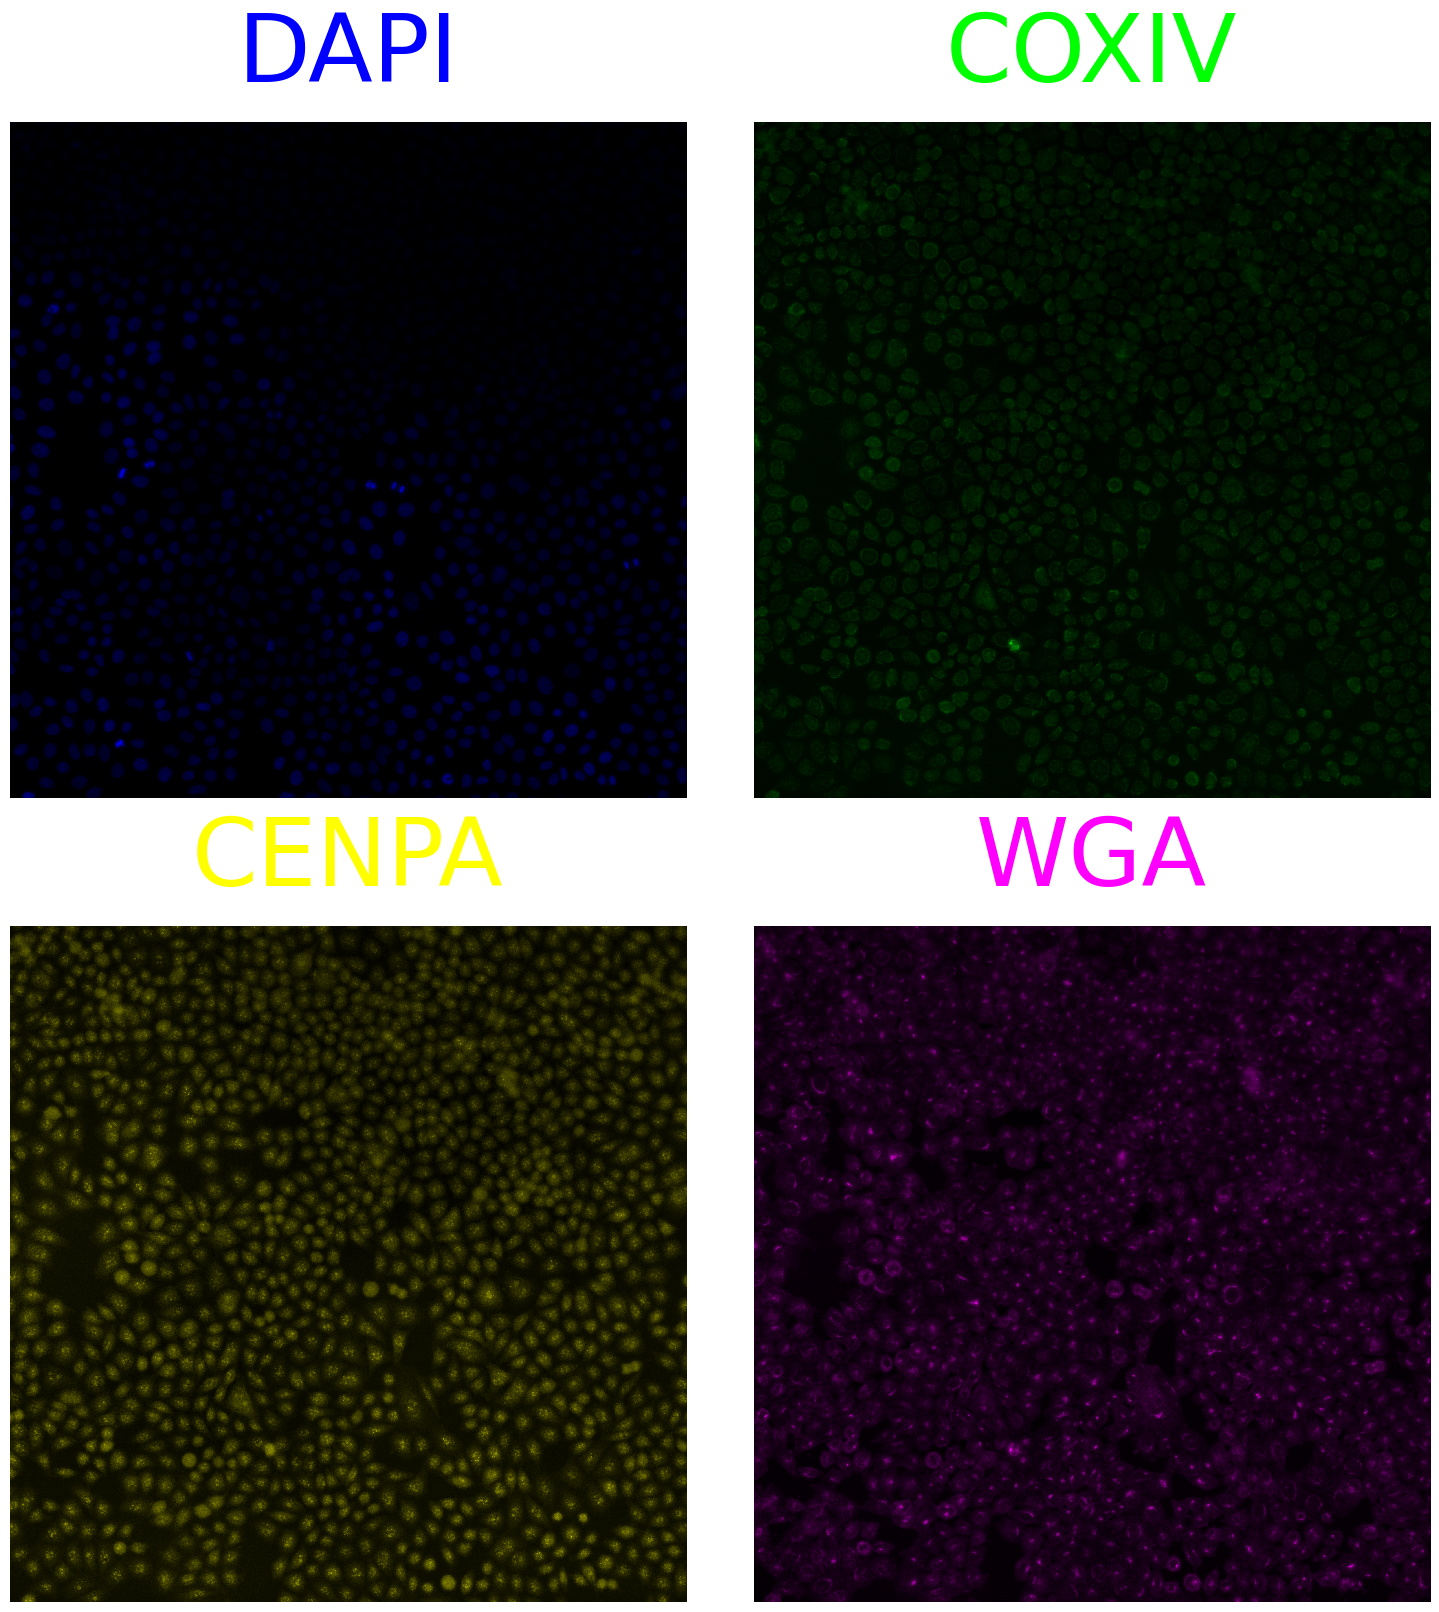

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names=CHANNEL_NAMES[0]
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names=CHANNEL_NAMES[1]
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names=CHANNEL_NAMES[2]
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names=CHANNEL_NAMES[3]
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Define parameters for CellPose segmentation
CYTO_CHANNEL = "COXIV"
NUCLEI_DIAMETER = 47.1
CELL_DIAMETER = 55.3
CYTO_MODEL = "cyto3"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

Segmenting cells...


/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

removing edges


found 1055 nuclei before reconciling
found 1111 cells before reconciling


reconciling masks with method how=consensus


found 970 nuclei/cells after reconciling


Number of nuclei segmented: 970
Number of cells segmented: 970
Example microplots for DAPI channel and nuclei segmentation:


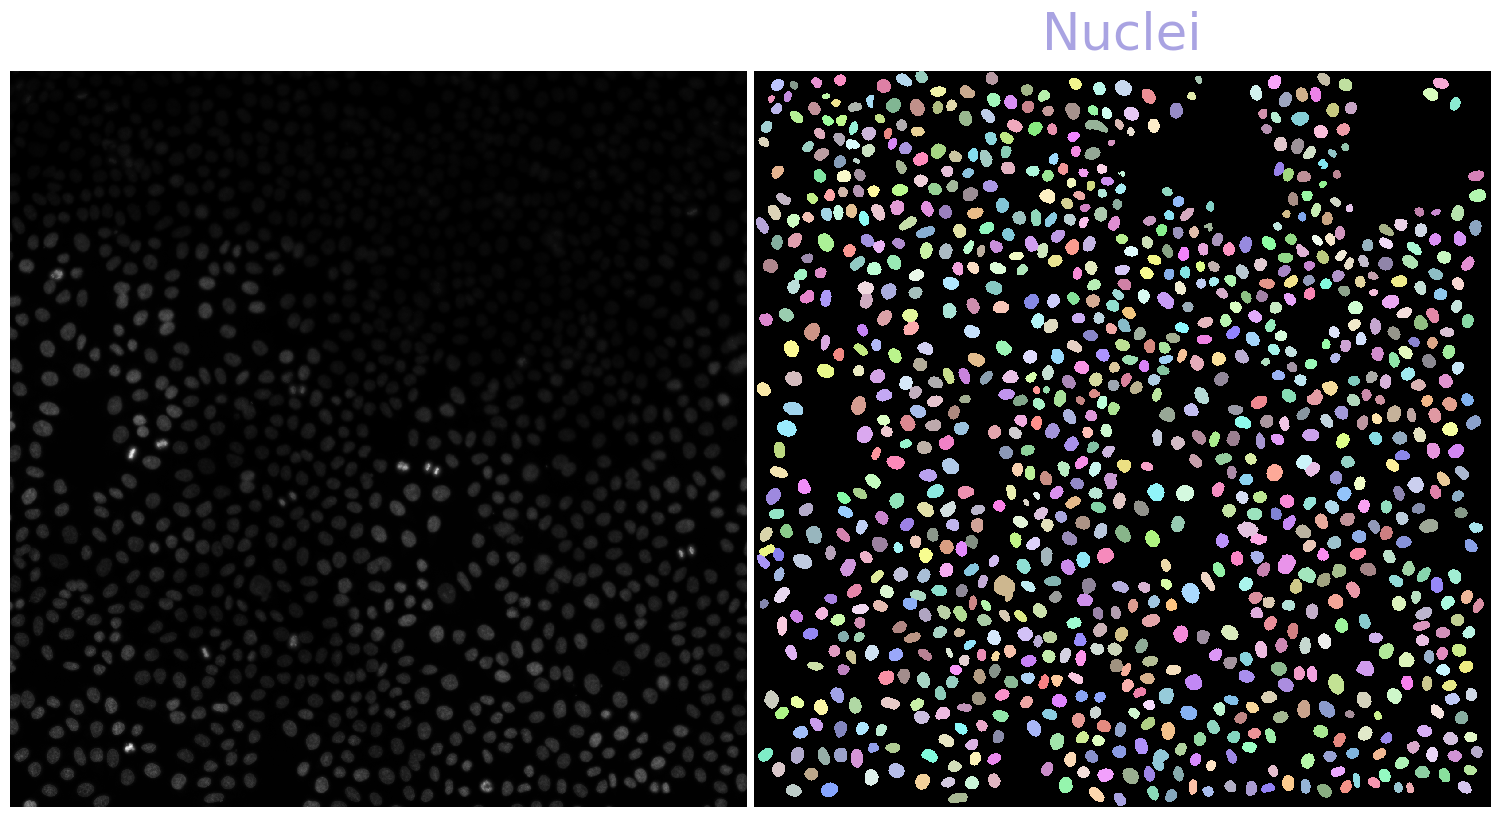

Example microplots for merged channels and cells segmentation:


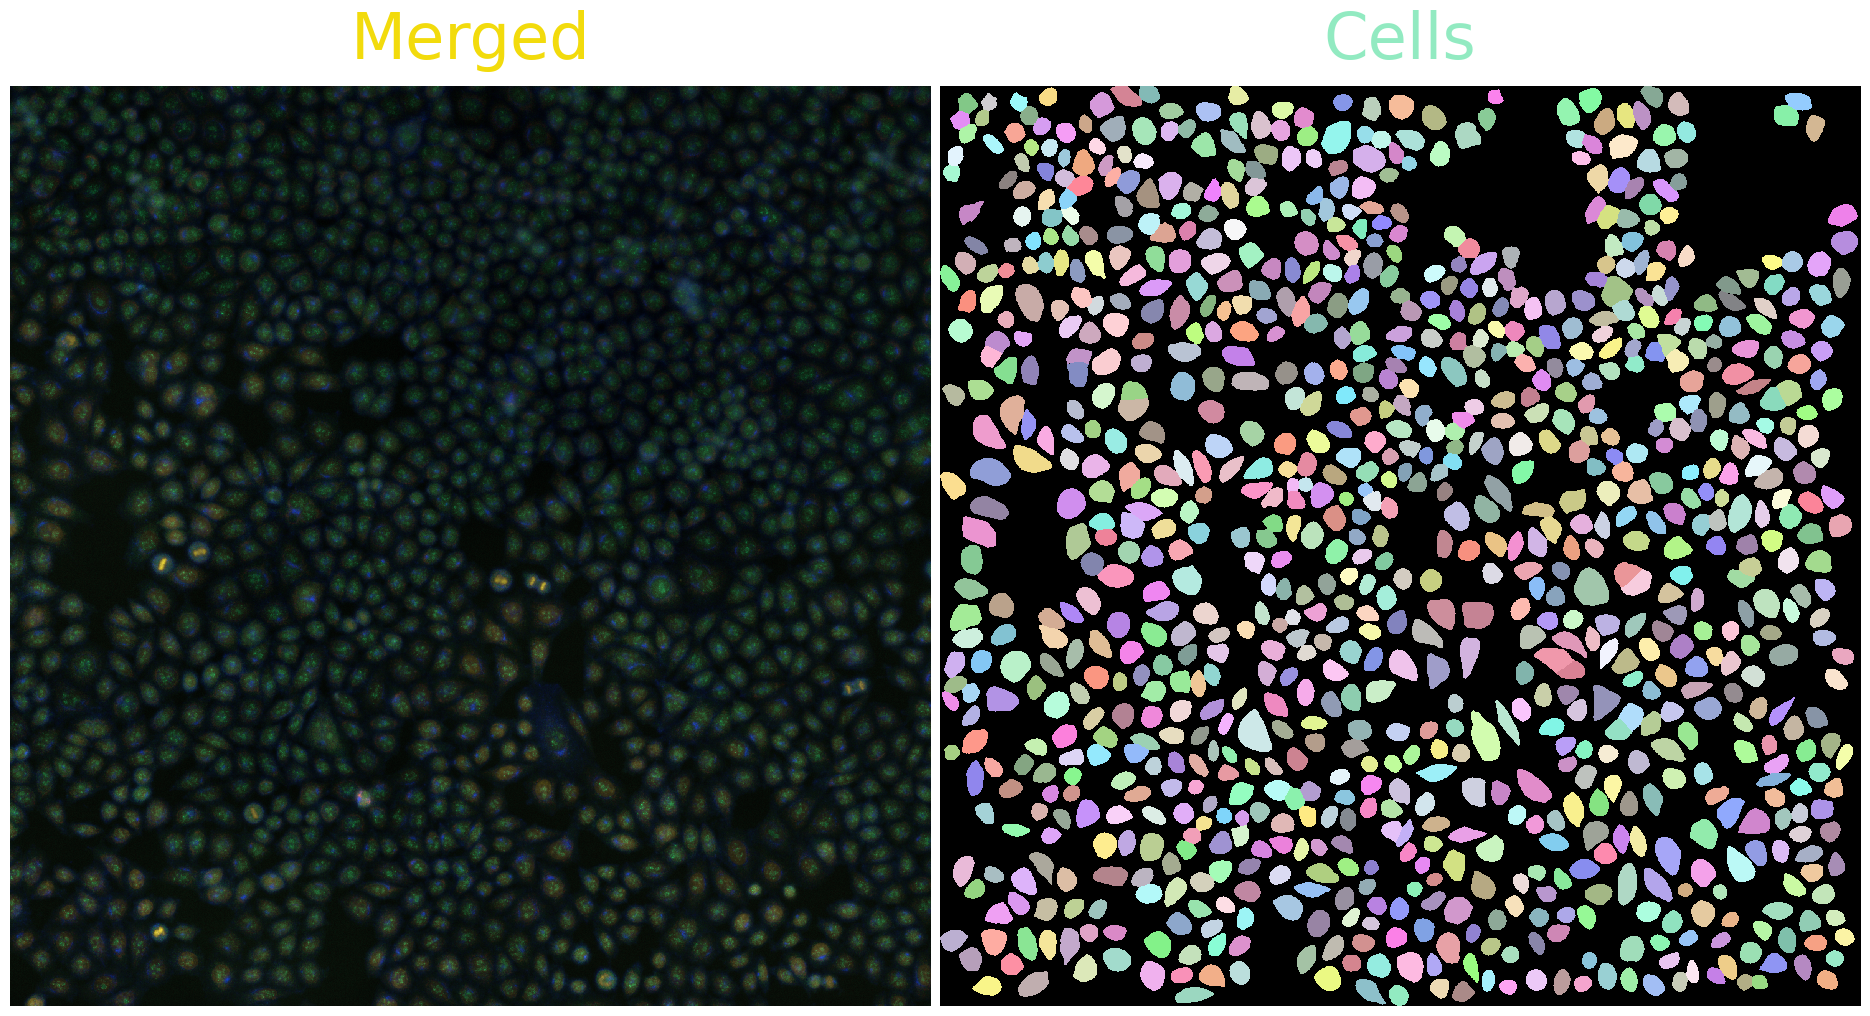

Example microplot for phenotype data annotated with segmenation:


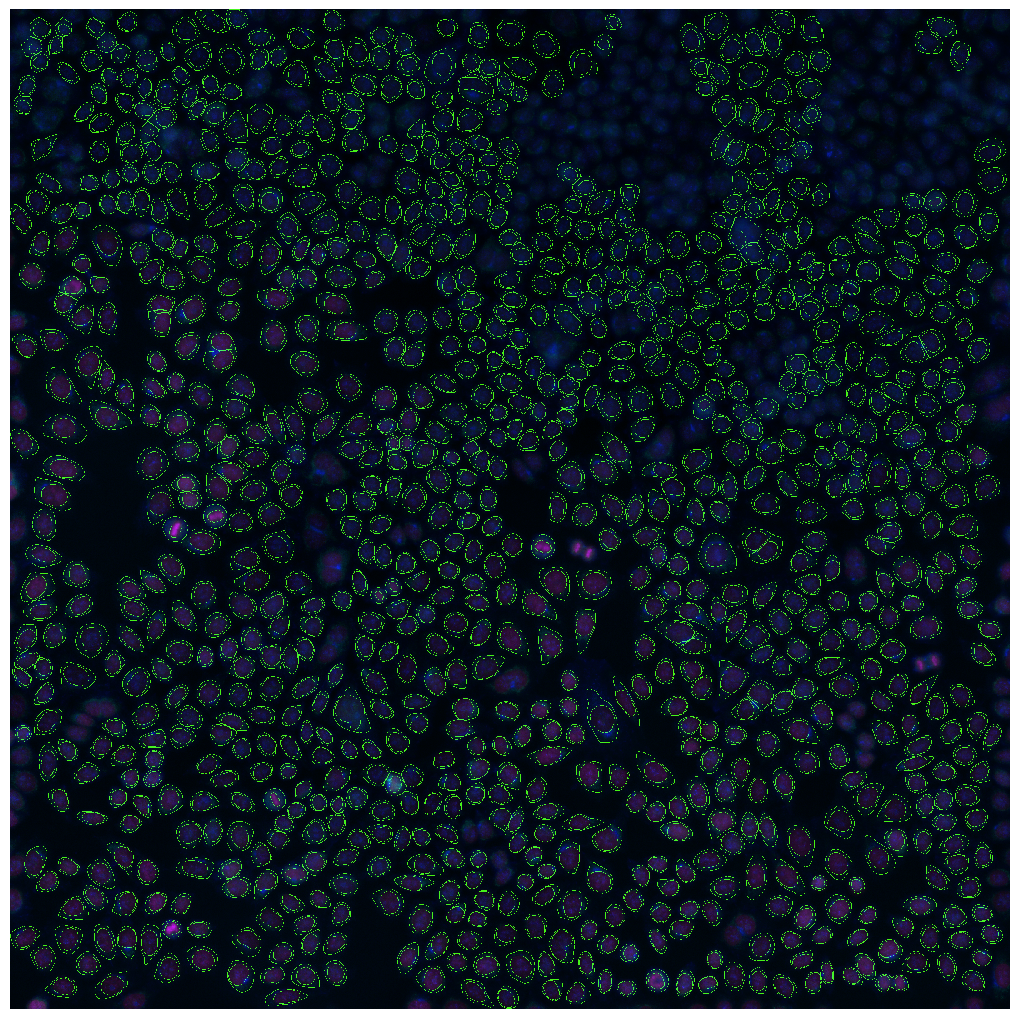

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 970


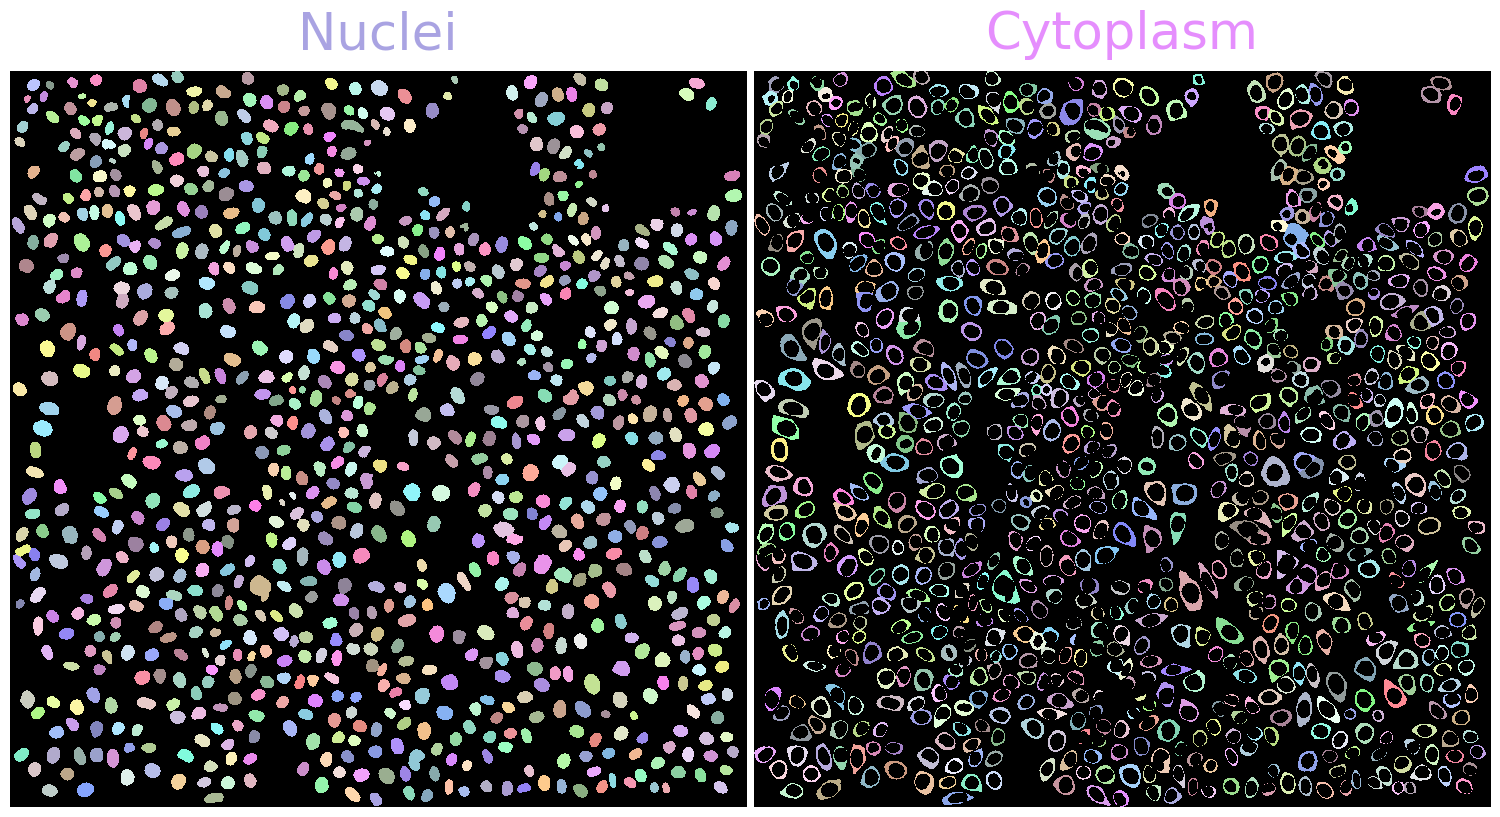

In [6]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL,
)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="DAPI")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

In [7]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    corrected_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_COXIV_int  nucleus_CENPA_int  \
0        1            775662             399501             450562   
1        2            817294             333645             375602   
2        3            624018             246419             324726   
3        4            614872             271997             361082   
4        5            500215             210875             289750   
..     ...               ...                ...                ...   
965    966           3742546             377333             457549   
966    967           3780727             379161             495693   
967    968           3479265             319634             448985   
968    969           4798556             413441             587509   
969    970           2800717             320947             439350   

     nucleus_WGA_int  nucleus_DAPI_mean  nucleus_COXIV_mean  \
0            3342408         605.512881          311.866511   
1            2714485         616.360483          251.617647   
2            2102376         483.360186          190.874516   
3            2943003         389.899810          172.477489   
4            2191807         450.238524          189.806481   
..               ...                ...                 ...   
965          3337759        3878.286010          391.018653   
966          3480728        2172.831609          217.908621   
967          3230552        2754.762470          253.075218   
968          4339568        2831.006490          243.917994   
969          3281525        2082.317472          238.622305   

     nucleus_CENPA_mean  nucleus_WGA_mean  nucleus_DAPI_std  ...  \
0            351.726776       2609.217799        135.166154  ...   
1            283.259427       2047.122926        124.559204  ...   
2            251.530596       1628.486445         79.941398  ...   
3            228.967660       1866.203551         64.761316  ...   
4            260.801080       1972.823582         68.631209  ...   
..                  ...               ...               ...  ...   
965          474.144041       3458.817617       1103.925473  ...   
966          284.881034       2000.418391        469.179979  ...   
967          355.490895       2557.840063        445.850087  ...   
968          346.612979       2560.217109        601.415544  ...   
969          326.654275       2439.795539        324.970422  ...   

     cell_number_neighbors_1  cell_percent_touching_1  \
0                          1                 0.090000   
1                          0                 0.000000   
2                          0                 0.000000   
3                          1                 0.065934   
4                          0                 0.000000   
..                       ...                      ...   
965                        0                 0.000000   
966                        0                 0.000000   
967                        0                 0.000000   
968                        0                 0.000000   
969                        0                 0.000000   

     cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                       58.720769                      72.331271   
1                       73.190835                      87.138637   
2                       57.709224                      71.713607   
3                       58.720769                      68.931511   
4                       70.060294                      78.364304   
..                            ...                            ...   
965                     54.945536                      75.072423   
966                     70.699798                      77.563689   
967                     60.663535                      70.460590   
968                     59.342708                      70.789843   
969                     77.563689                      81.592759   

     cell_angle_between_neighbors  cytoplasm_number_neighbors_1  \
0                    

In [8]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature

# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

In [9]:
# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "cyto_model": CYTO_MODEL,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)